# Bayesian Neural Networks toy examples

In [1]:
#### If you need to install packages use this as an example
# import sys
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m pip install matplotlib

# !conda install --yes --prefix {sys.prefix} pytorch torchvision torchaudio -c pytorch
# !{sys.executable} -m pip install torchbnn

In [2]:
import math
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchbnn as bnn
from sklearn import datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar

# Training Data
will need a training and a test set. Instead of splitting an existing dataset, I will just generate different ones with sklearn

In [3]:
def get_dataset(n_samples, noise=0.2):
    """Get dataset, reformat to pandas and visualize
    
    Args:
        n_samples (int): size of dataset
        noise (float): level of noise
    """
    # Moon dataset
    dataset = datasets.make_moons(n_samples=n_samples, noise=noise)
    X, y = dataset

    # Pandas reformatting
    df_data = pd.DataFrame(X, columns=["x", "y"])
    df_data["label"] = y.reshape(-1)
    df_data["id"] = df_data.index

    # torch data formatting
    X_tensor = torch.tensor(X)
    # y array of shape (n_samples,1)
    y = np.reshape(y, (len(y), 1))
    inputs = torch.tensor(X, dtype=torch.float)
    labels = torch.tensor(y, dtype=torch.long)
    labels = labels.reshape(-1)

    return inputs, labels, df_data

In [4]:
# training dataset
train_samples = 10000
train_noise = 0.2
train_inputs, train_labels, train_df_data = get_dataset(
    train_samples, noise=train_noise
)
train_dataset_tuple = (train_noise, train_inputs, train_labels)

In [5]:
train_df_data

,x,y,label,id
0,1.390525,-0.109685,1,0
1,0.647143,-0.327801,1,1
2,0.253411,-0.267667,1,2
3,0.155663,0.923857,0,3
4,-0.365603,0.593477,0,4
...,...,...,...,...
9995,0.299566,-0.429684,1,9995
9996,1.388693,-0.153812,1,9996
9997,-0.504003,0.655923,0,9997
9998,0.343207,1.048357,0,9998


Let's visualize the training set

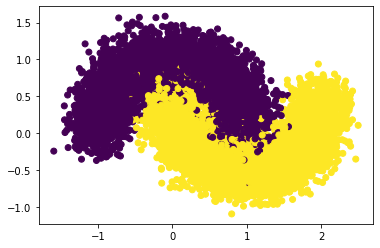

In [6]:
plt.scatter(train_df_data.x,train_df_data.y,c=train_df_data.label)

# A Simple Network (non Bayesian)

In [7]:
# network settings
settings = {}
settings["nb_layers"] = 3
settings["learning_rate"] = 1e-3
settings["input_size"] = 2
settings["nb_classes"] = 2
settings["hidden_dim"] = 128

In [8]:
class Simple_NN(nn.Module):
    def __init__(self, settings):
        super().__init__()

        # init
        self.nb_classes = settings["nb_classes"]
        self.input_size = settings["input_size"]
        self.hidden_size = settings["hidden_dim"]
        self.nb_layers = settings["nb_layers"]

        # Define structure
        self.layer1 = nn.Linear(self.input_size, self.hidden_size)
        self.layer2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.layer3 = nn.Linear(self.hidden_size, self.nb_classes)
    
    # how data will go through the model
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
            
        # we could add at the end the softmax to get the classification
        # but we choose to do it separetely
        # output = nn.functional.softmax(x, dim=1)

        return x

### Training

In [9]:
criterion = nn.CrossEntropyLoss(reduction="sum")
Simple_NN = Simple_NN(settings)
optimizer = torch.optim.Adam(Simple_NN.parameters(), lr=settings["learning_rate"])

# train network
for epochs in range(1000):
    # Set NN to train mode (deals with dropout and batchnorm)
    Simple_NN.train()

    # Zero out the gradients
    optimizer.zero_grad()

    # Forward pass
    output = Simple_NN(train_inputs)
    clf_loss = criterion(output.squeeze(), train_labels)

    loss = (clf_loss) / train_inputs.shape[0]

    # Backward pass
    loss.backward()
    optimizer.step()


### Predictions

In [10]:
#dataset
test_inputs, test_labels, test_df_data = get_dataset(1000, noise=0.1)

In [11]:
# get preds
Simple_NN.eval()
output = Simple_NN(test_inputs)
pred_proba = nn.functional.softmax(output, dim=1)
df_preds = pd.DataFrame(
    pred_proba.data.cpu().numpy(), columns=["class0", "class1"]
)
df_preds['id'] = df_preds.index
df_preds

,class0,class1,id
0,0.001281,0.998719,0
1,0.999661,0.000339,1
2,0.006698,0.993302,2
3,0.001381,0.998619,3
4,0.998192,0.001808,4
...,...,...,...
995,0.019555,0.980445,995
996,0.000003,0.999997,996
997,0.000196,0.999804,997
998,0.001395,0.998605,998


#### Visualization

In [12]:
df = test_df_data.merge(df_preds, on="id")

Text(0.5, 1.0, 'Predictions')

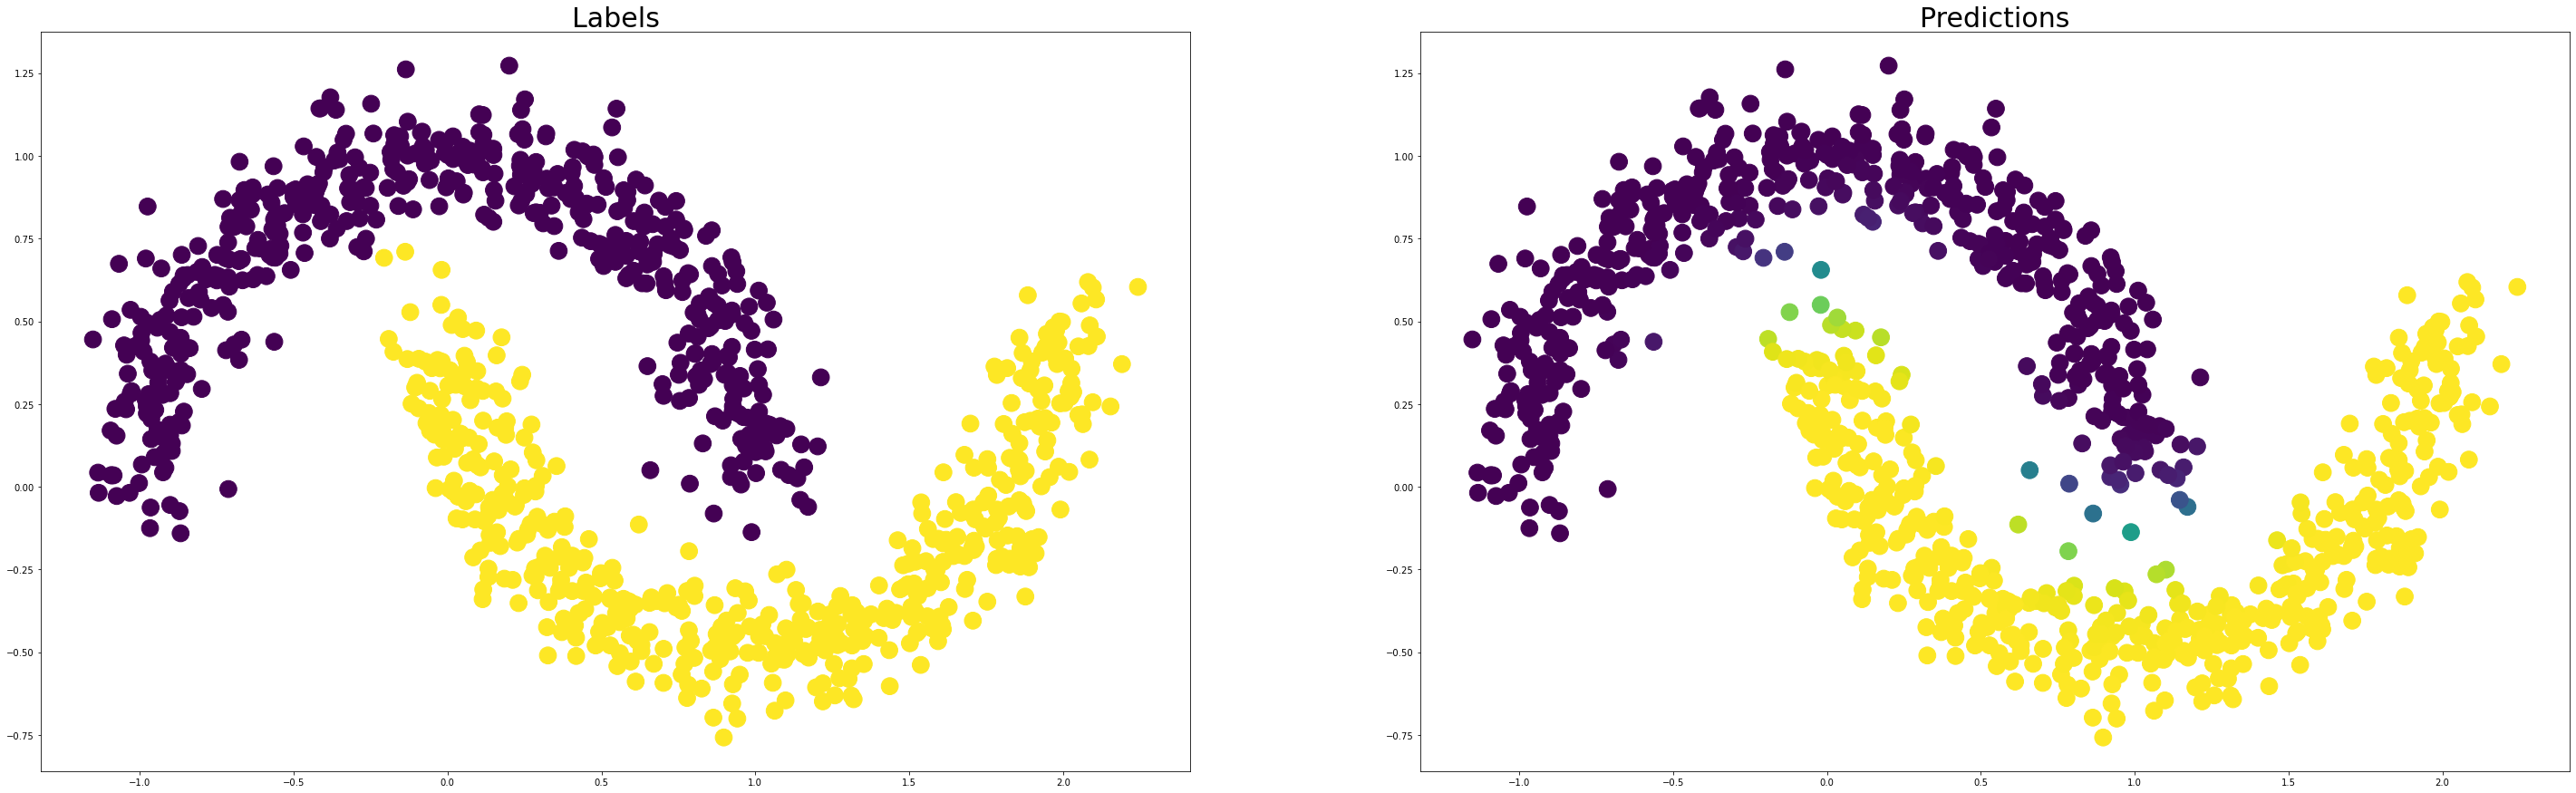

In [13]:
fig = plt.figure(figsize=(50, 15))
gs = gridspec.GridSpec(1, 2)
ax = plt.subplot(gs[0])
ax.scatter(df.x,df.y,c=df.label,s=350)
ax.set_title('Labels',fontsize=30)
ax1 = plt.subplot(gs[1])
ax1.scatter(df.x,df.y,c=df.class1,s=350)
ax1.set_title('Predictions',fontsize=30)

#### and if my dataset is noisier?

Text(0.5, 1.0, 'Predictions')

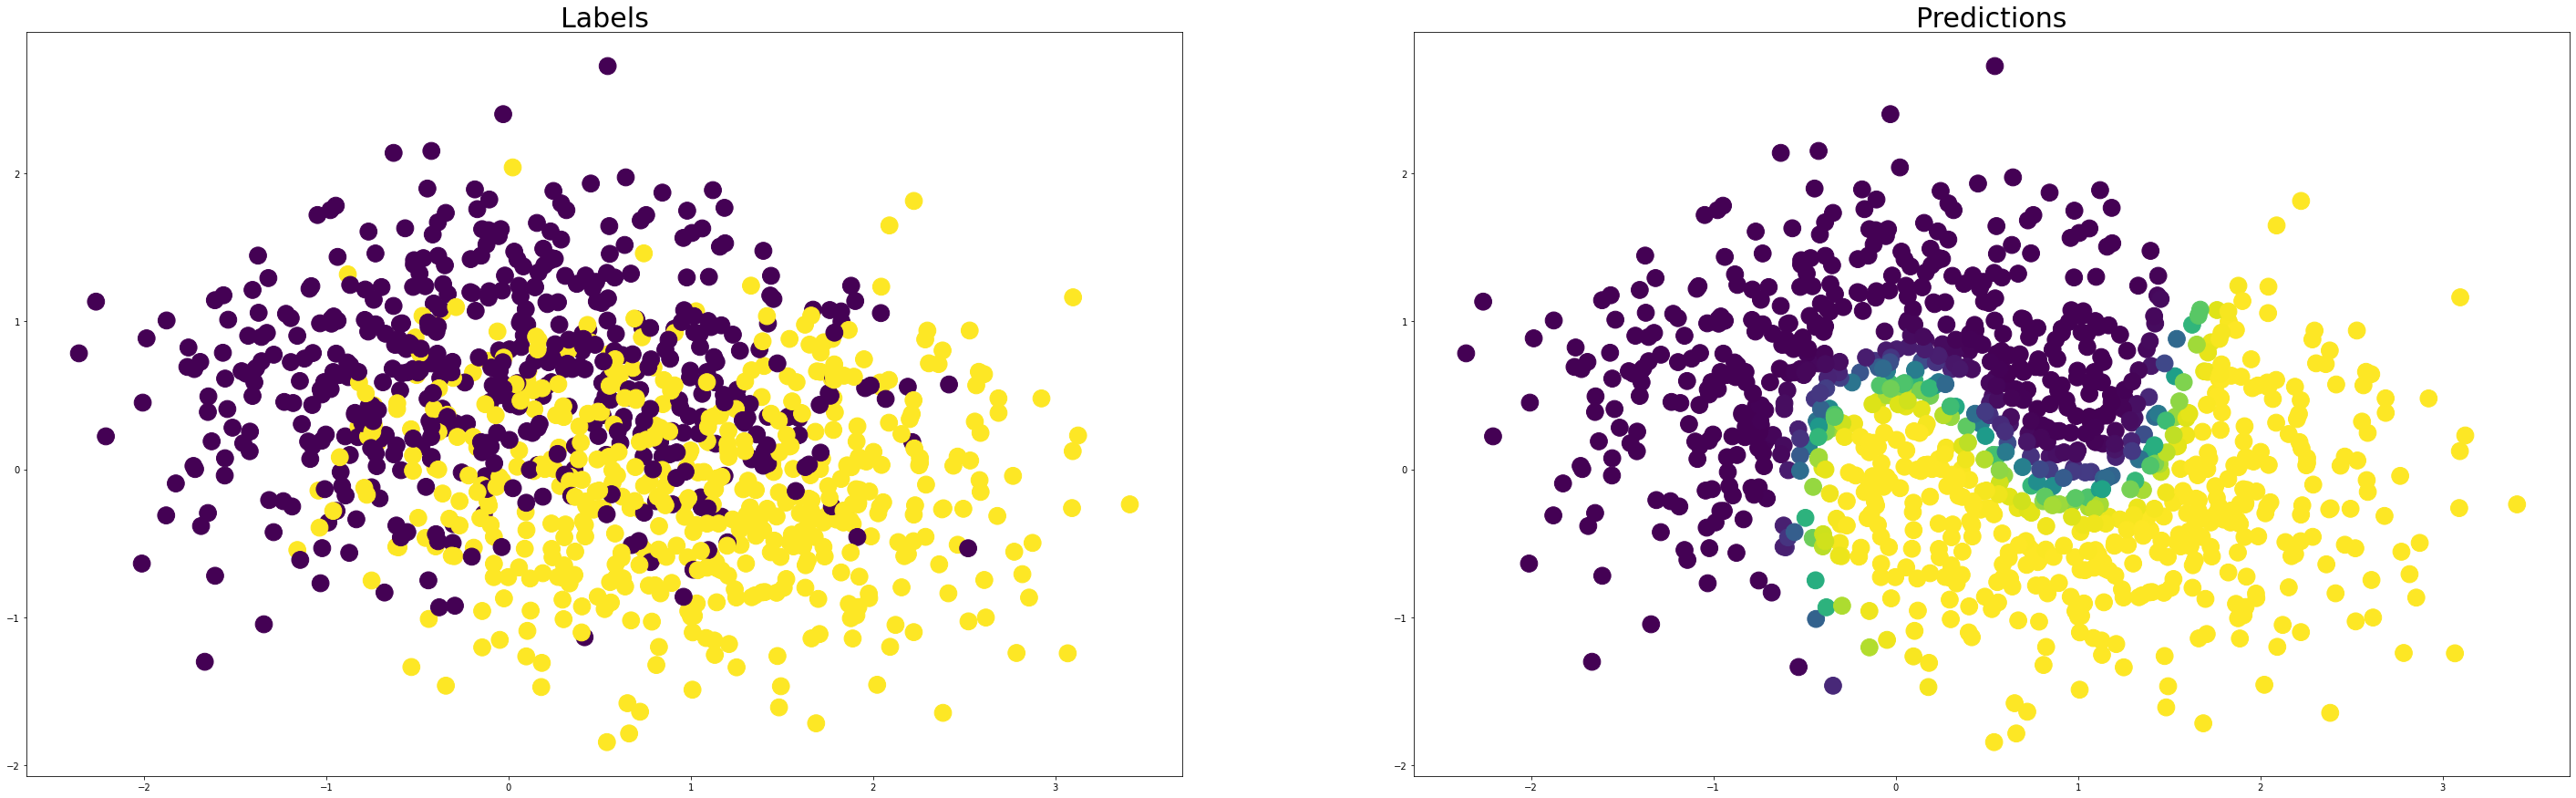

In [14]:
#dataset
test_inputs, test_labels, test_df_data = get_dataset(1000, noise=0.6)
# get preds
Simple_NN.eval()
output = Simple_NN(test_inputs)
pred_proba = nn.functional.softmax(output, dim=1)
df_preds = pd.DataFrame(
    pred_proba.data.cpu().numpy(), columns=["class0", "class1"]
)
df_preds['id'] = df_preds.index
df = test_df_data.merge(df_preds, on="id")
# plot
fig = plt.figure(figsize=(50, 15))
gs = gridspec.GridSpec(1, 2)
ax = plt.subplot(gs[0])
ax.scatter(df.x,df.y,c=df.label,s=350)
ax.set_title('Labels',fontsize=30)
ax1 = plt.subplot(gs[1])
ax1.scatter(df.x,df.y,c=df.class1,s=350)
ax1.set_title('Predictions',fontsize=30)

Look at the. very high confidence predictions for samples that were not even close to the training set! Our model should not be confident there... Thats why we explore BNNs

# Defining my BNN

Here, I am defining a NN that can be Bayesian or non-Bayesian just by changing how weights are computed. The logic of the definition is the same as above, just there are more components since the Bayesian Layers are defined here and not imported from torch

In [15]:
# network settings
settings = {}
settings["nb_layers"] = 3
settings["learning_rate"] = 1e-3
settings["input_size"] = 2
settings["nb_classes"] = 2
settings["hidden_dim"] = 128
settings["pi"] = 0.75
settings["log_sigma1"] = -1.0
settings["log_sigma2"] = -7.0
settings["rho_scale_lower"] = 4.0
settings["rho_scale_upper"] = 3.0

In [34]:
class BNN(nn.Module):
    def __init__(self, settings):
        super().__init__()

        # init
        self.nb_classes = settings["nb_classes"]
        self.input_size = settings["input_size"]
        self.hidden_size = settings["hidden_dim"]
        self.nb_layers = settings["nb_layers"]

        # The Bayesian part
        # Need to define a prior... here is a mixture of gaussians
        self.prior = Prior(
            settings["pi"], settings["log_sigma1"], settings["log_sigma2"]
        )
        print(self.prior)

        # Define structure
        self.layers = nn.ModuleDict()
        # Allow nb_layers to change
        for i in range(self.nb_layers):
            input_size = self.hidden_size
            output_size = self.hidden_size
            if i == 0:
                input_size = self.input_size
            elif i == self.nb_layers - 1:
                output_size = self.nb_classes   

            # all layers are Bayes Linear (see below for definition)
            self.layers[f"{i}"] = BayesLinear(
                input_size,
                output_size,
                self.prior,
                mu_lower=-0.2,
                mu_upper=0.2,
                rho_lower=math.log(
                    math.exp(
                        self.prior.sigma_mix / settings["rho_scale_lower"]
                    )
                    - 1.0
                ),
                rho_upper=math.log(
                    math.exp(
                        self.prior.sigma_mix / settings["rho_scale_upper"]
                    )
                    - 1.0
                ),
            )
    
    # how data will go through the model
    def forward(self, x, force_nonbayesian=False):
        self.kl = 0
        # the only difference from a simple NN is that we are computing KL and saving it
        for i in range(self.nb_layers):
            x = self.layers[f"{i}"](x, force_nonbayesian=force_nonbayesian)
            # Use the rectified-linear activation function over x
            # if not the last layer
            if i != self.nb_layers - 1:
                x = F.relu(x)
            # KL
            self.kl += self.layers[f"{i}"].kl
            
        # we could add at the end the softmax to get the classification
        # but we choose to do it separetely
        # output = nn.functional.softmax(x, dim=1)

        return x

### Defining my Bayesian layer
- if it was not bayesian we could use something already in the library like nn.Conv2d or Linear layers
- another option is use an existing implementation of this Bayesian Layer (github has soooo many)
- but here I want to write my own linear layer

In [17]:
class BayesLinear(nn.Module):
    def __init__(
        self, in_features, out_features, prior, mu_lower, mu_upper, rho_lower, rho_upper
    ):
        # initializing the parent class
        # (nn.Module)
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.prior = prior

        # we could initialize mu,rho in any way
        # See https://github.com/Harry24k/bayesian-neural-network-pytorch/blob/master/torchbnn/modules/linear.py
        # empirically is better to use the priors as reference
        mu, rho = get_bbb_variable(
            (out_features, in_features), mu_lower, mu_upper, rho_lower, rho_upper
        )
        bias = nn.Parameter(torch.Tensor(out_features))
        bias.data.fill_(0.0)
        self.mu = mu
        self.rho = rho
        self.bias = bias
        self.kl = None

    def forward(self, input, force_nonbayesian=False):

        # Sample weight
        mean = self.mu
        sigma = F.softplus(self.rho) + 1e-5

        if force_nonbayesian:
            # when sampling the weight we just use the mean
            # deterministic weight
            weights = mean
        else:
            # Obtain posterior sample of the weights (gaussian)
            # by sampling epsilon normal distribution
            # This way of creating the epsilon variable is faster than
            # from numpy or torch.randn or FloatTensor.normal_ when mean is on the GPU
            eps = mean.data.new(mean.size()).normal_(0.0, 1.0)
            weights = mean + eps * sigma

        logits = F.linear(input, weights, self.bias)

        # Compute KL divergence
        self.kl = compute_KL(weights, mean, sigma, self.prior)

        return logits

    def __repr__(self):
        # printing function
        return (
            self.__class__.__name__
            + " ("
            + str(self.in_features)
            + " -> "
            + str(self.out_features)
            + ")"
        )


In [18]:
def get_bbb_variable(shape, mu_lower, mu_upper, rho_lower, rho_upper):
    """Initialize weights using prior initialization
    """

    mu = nn.Parameter(torch.Tensor(*shape))
    rho = nn.Parameter(torch.Tensor(*shape))

    mu.data.uniform_(mu_lower, mu_upper)
    rho.data.uniform_(rho_lower, rho_upper)

    return mu, rho

In [19]:
class Prior(object):
    def __init__(self, pi=0.25, log_sigma1=-1.0, log_sigma2=-7.0):
        """the prior is initialized as mixture of Gaussians
        """

        self.pi_mixture = pi
        self.log_sigma1 = log_sigma1
        self.log_sigma2 = log_sigma2
        self.sigma1 = math.exp(log_sigma1)
        self.sigma2 = math.exp(log_sigma2)

        self.sigma_mix = math.sqrt(
            pi * math.pow(self.sigma1, 2) + (1.0 - pi) * math.pow(self.sigma2, 2)
        )

    def __repr__(self):
        # printing function
        return (
            self.__class__.__name__
            + " ("
            + str(self.pi_mixture)
            + ", "
            + str(self.log_sigma1)
            + ", "
            + str(self.log_sigma2)
            + ")"
        )


In [20]:
def compute_KL(x, mu, sigma, prior):
    """ KL divergence
    """

    posterior = torch.distributions.Normal(mu.view(-1), sigma.view(-1))
    log_posterior = posterior.log_prob(x.view(-1)).sum()

    if x.is_cuda:
        n1 = torch.distributions.Normal(
            torch.tensor([0.0]).cuda(), torch.tensor([prior.sigma1]).cuda()
        )
        n2 = torch.distributions.Normal(
            torch.tensor([0.0]).cuda(), torch.tensor([prior.sigma2]).cuda()
        )
    else:
        n1 = torch.distributions.Normal(0.0, prior.sigma1)
        n2 = torch.distributions.Normal(0.0, prior.sigma2)

    mix1 = torch.sum(n1.log_prob(x)) + math.log(prior.pi_mixture)
    mix2 = torch.sum(n2.log_prob(x)) + math.log(1.0 - prior.pi_mixture)
    prior_mix = torch.stack([mix1, mix2])
    log_prior = torch.logsumexp(prior_mix, 0)

    return log_posterior - log_prior


## Define function to train network

In [21]:
def train_network(
    my_nn,
    settings,
    inputs,
    labels,
    force_nonbayesian=False,
    outmodel_name="./model.pt",
):

    criterion = nn.CrossEntropyLoss(reduction="sum")
    my_nn = my_nn(settings)
    optimizer = torch.optim.Adam(my_nn.parameters(), lr=settings["learning_rate"])

    # train network
    for epochs in range(1000):
        # Set NN to train mode (deals with dropout and batchnorm)
        my_nn.train()

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        output = my_nn(inputs, force_nonbayesian)
        clf_loss = criterion(output.squeeze(), labels)

        if force_nonbayesian:
            loss = (clf_loss) / inputs.shape[0]
        else:
            # Special case for Bayesian my_nn, need to use KL loss
            loss = (clf_loss + my_nn.kl) / inputs.shape[0]

        # Backward pass
        loss.backward()
        optimizer.step()


    torch.save(my_nn.state_dict(), outmodel_name)

    return my_nn

In [22]:
my_nn = BNN
force_nonbayesian = True
my_nn = train_network(
                my_nn,
                settings,
                train_inputs,
                train_labels,
                outmodel_name=f"model.pt",
                force_nonbayesian=force_nonbayesian,
            )

Prior (0.75, -1.0, -7.0)


# Evaluate

In [23]:
# test set
test_samples = 1000
noise_value = 0.1
test_inputs, test_labels, test_df_data = get_dataset(test_samples, noise=noise_value)

## predictions

In [24]:
def get_my_nn_predictions(rnn, inputs, force_nonbayesian=False):
    if force_nonbayesian:
        n_inference_samples = 1
    else:
        n_inference_samples = 20
    dic_df_preds = {}
    for inf in range(n_inference_samples):
        rnn.eval()
        output = rnn(inputs)
        pred_proba = nn.functional.softmax(output, dim=1)
        dic_df_preds[inf] = pd.DataFrame(
            pred_proba.data.cpu().numpy(), columns=["class0", "class1"]
        )
        dic_df_preds[inf]["id"] = dic_df_preds[inf].index
    df_preds = pd.concat(dic_df_preds)
    return df_preds

In [25]:
df_preds = get_my_nn_predictions(
    my_nn, test_inputs, force_nonbayesian=force_nonbayesian
)

In [26]:
df_preds

class0    class1   id
0 0    0.972300  0.027700    0
  1    0.003747  0.996253    1
  2    0.000385  0.999615    2
  3    0.999592  0.000408    3
  4    0.999896  0.000104    4
...         ...       ...  ...
  995  0.999994  0.000006  995
  996  0.003908  0.996092  996
  997  0.999736  0.000264  997
  998  0.002192  0.997808  998
  999  0.000293  0.999707  999

[1000 rows x 3 columns]

### Lets plot some results

In [27]:
def reformat_predictions(df_preds, df_data):
    # aggregate predictions
    df_preds_agg = df_preds.groupby(by="id").median()
    df_preds_agg[["class0_std", "class1_std"]] = df_preds.groupby(by="id").std()
    df_preds[df_preds["id"] == 0]

    # get predicted target
    df_preds_agg["predicted_target"] = (
        df_preds_agg[[k for k in df_preds_agg.keys() if "std" not in k]]
        .idxmax(axis=1)
        .str.strip("class")
        .astype(int)
    )

    # merge with original data
    merged_preds = df_data.merge(df_preds_agg, on="id")

    return merged_preds

In [28]:
df = reformat_predictions(df_preds, test_df_data)

In [29]:
df

,x,y,label,id,class0,class1,class0_std,class1_std,predicted_target
0,0.989768,0.343524,0,0,0.972300,0.027700,NaN,NaN,0
1,0.696496,-0.421158,1,1,0.003747,0.996253,NaN,NaN,1
2,0.255001,-0.158926,1,2,0.000385,0.999615,NaN,NaN,1
3,-0.029297,1.059386,0,3,0.999592,0.000408,NaN,NaN,0
4,-0.914788,0.230209,0,4,0.999896,0.000104,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...
995,-0.964299,0.634963,0,995,0.999994,0.000006,NaN,NaN,0
996,1.913857,-0.184743,1,996,0.003908,0.996092,NaN,NaN,1
997,-0.598413,0.732876,0,997,0.999736,0.000264,NaN,NaN,0
998,1.557741,-0.431053,1,998,0.002192,0.997808,NaN,NaN,1


Text(0.5, 1.0, 'Predictions')

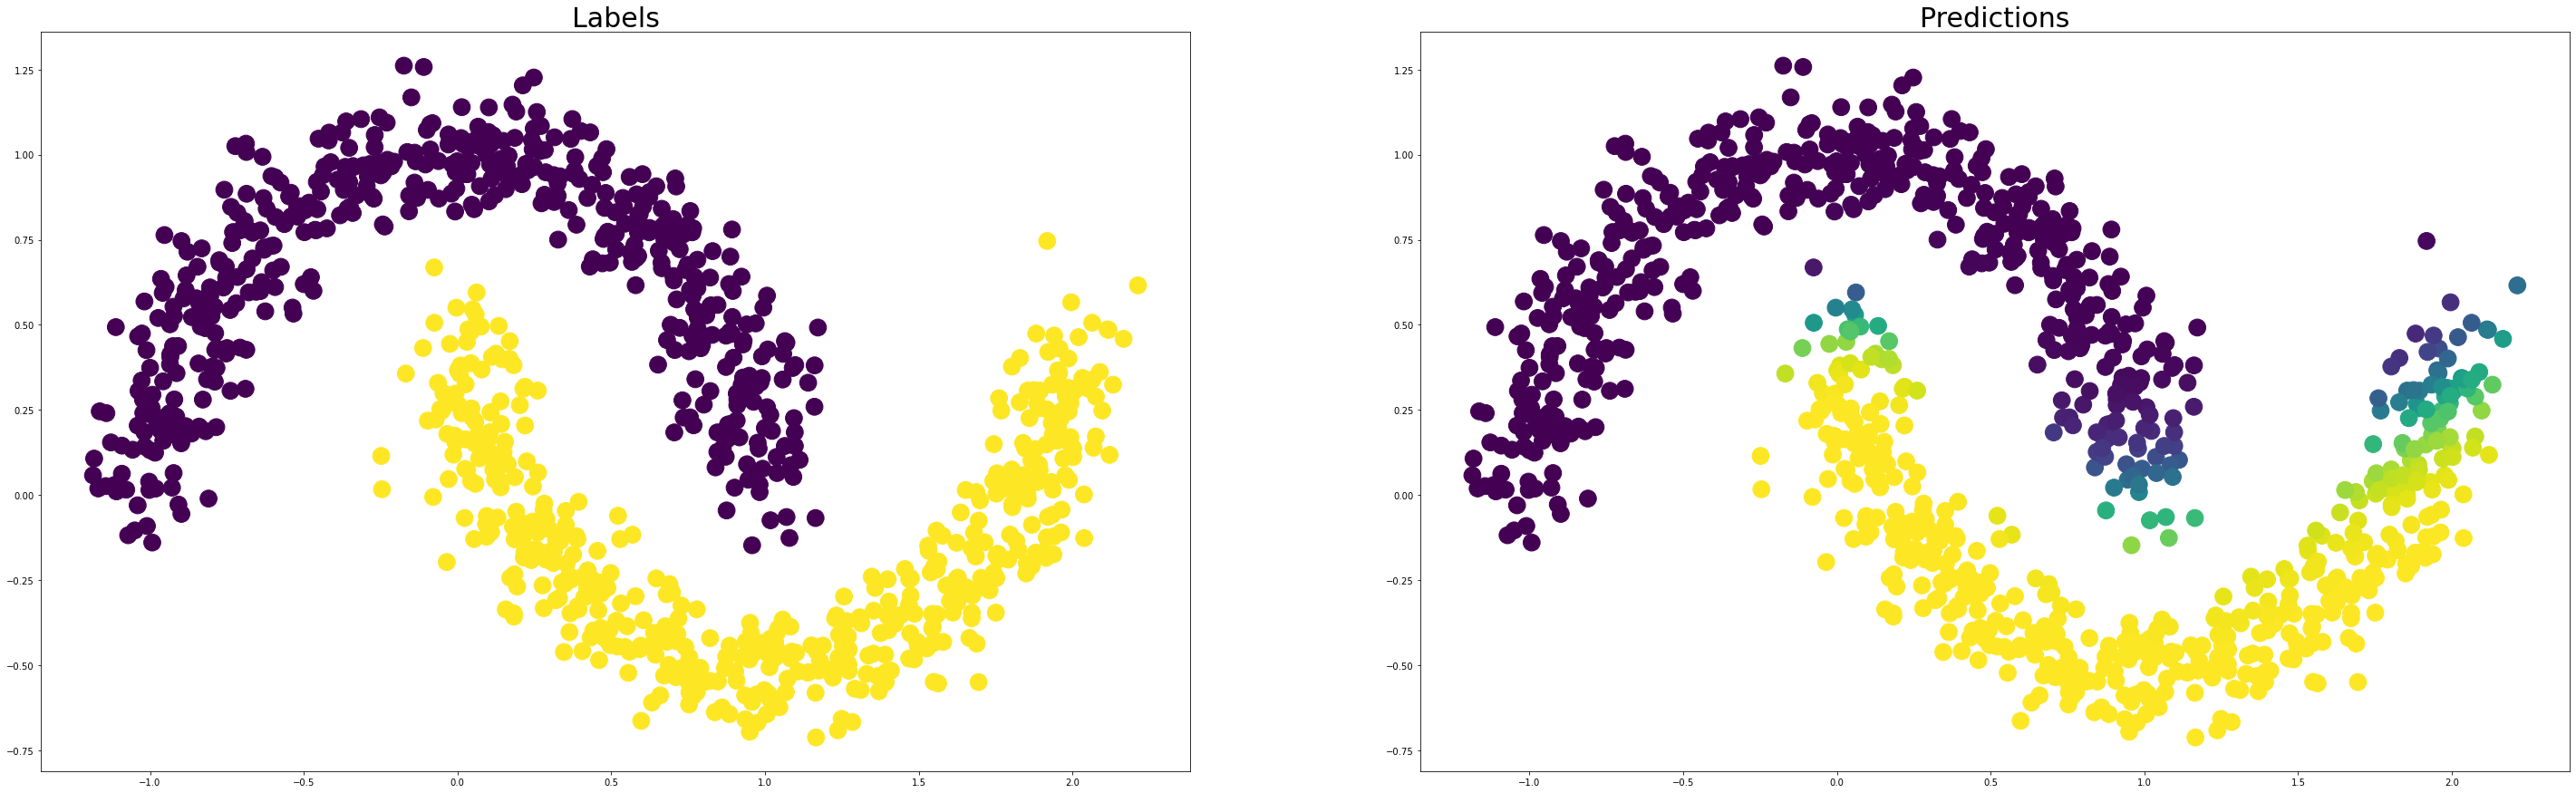

In [30]:
fig = plt.figure(figsize=(50, 15))
gs = gridspec.GridSpec(1, 2)
ax = plt.subplot(gs[0])
ax.scatter(df.x,df.y,c=df.label,s=350)
ax.set_title('Labels',fontsize=30)
ax1 = plt.subplot(gs[1])
ax1.scatter(df.x,df.y,c=df.class1,s=350)
ax1.set_title('Predictions',fontsize=30)

# Evaluate BNN predictions for datasets with different noise

In [31]:
dic_preds = {}
list_noise_values = [0.1, 0.2, 0.3]
force_nonbayesian  = False
for noise_value in list_noise_values:
    # get preds
    test_inputs, test_labels, test_df_data = get_dataset(test_samples, noise=noise_value
    )
    df_preds = get_my_nn_predictions(
        my_nn, test_inputs, force_nonbayesian=force_nonbayesian
    )
    dic_preds[noise_value] = reformat_predictions(df_preds, test_df_data)

In [32]:
dic_preds

{0.1:             x         y  label   id    class0    class1  class0_std  \
 0   -0.081219  0.312731      1    0  0.020516  0.979484    0.018883   
 1   -1.186444  0.057801      0    1  0.999997  0.000003    0.004679   
 2   -0.920484  0.036553      0    2  0.999796  0.000204    0.056816   
 3    1.782364  0.125336      1    3  0.000102  0.999898    0.004773   
 4    1.650137 -0.286276      1    4  0.000027  0.999973    0.002360   
 ..        ...       ...    ...  ...       ...       ...         ...   
 995  1.792903  0.107472      1  995  0.000080  0.999920    0.003821   
 996  0.907922  0.603622      0  996  0.980954  0.019046    0.155781   
 997  1.521450 -0.312113      1  997  0.000104  0.999896    0.006620   
 998  0.722109  0.507292      0  998  0.972465  0.027535    0.136889   
 999 -1.073099  0.162935      0  999  0.999989  0.000011    0.009957   
 
      class1_std  predicted_target  
 0      0.018883                 1  
 1      0.004679                 0  
 2      0.056816  

/var/folders/hj/2gy38d5s5mj7n7cln0xf7kjh249zrd/T/ipykernel_3722/1790227542.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/hj/2gy38d5s5mj7n7cln0xf7kjh249zrd/T/ipykernel_3722/1790227542.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


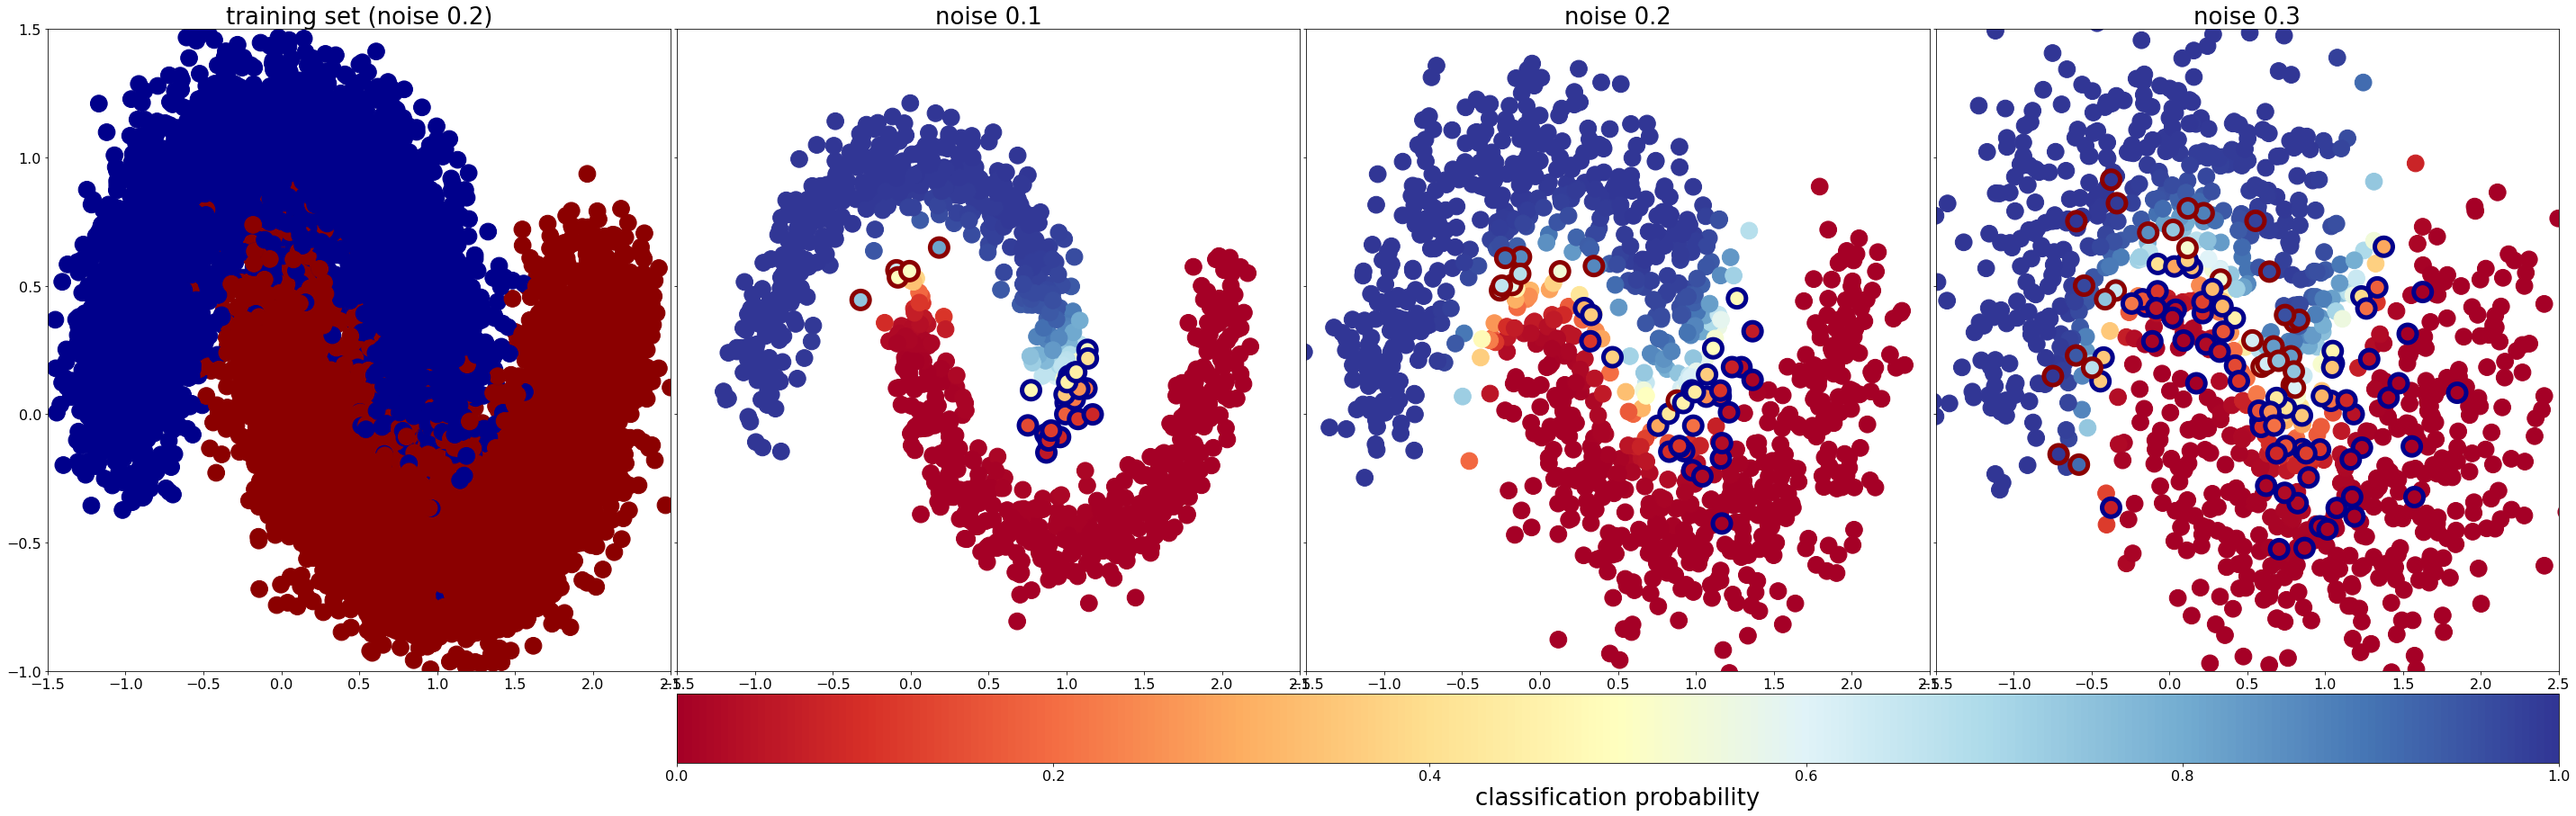

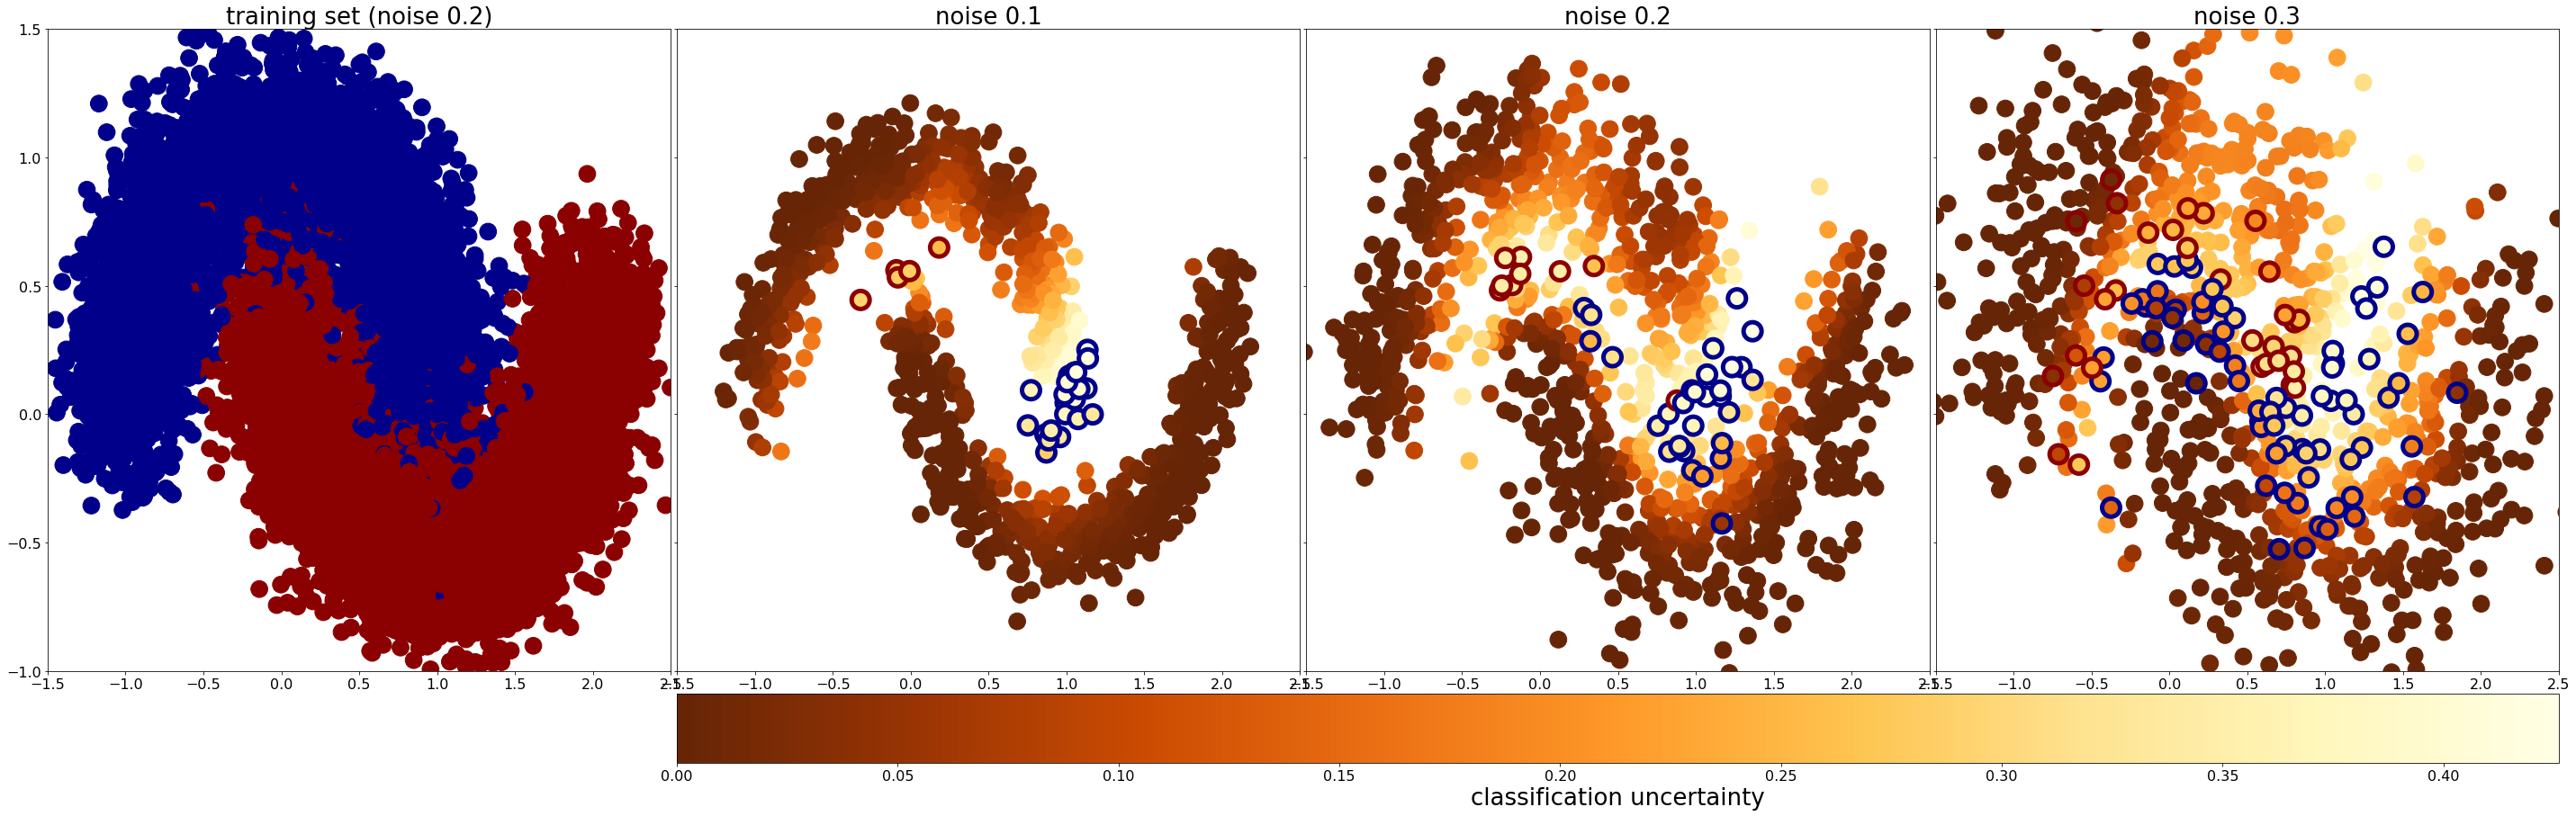

In [33]:
# BNNs provide probability + uncertainty
keys = ["class0", "class0_std"]
outnames = ["probability", "uncertainty"]

for outname, key in zip(outnames, keys):
    cmap = plt.cm.RdYlBu if outname == "probability" else plt.cm.YlOrBr_r
    fig = plt.figure(figsize=(50, 15))
    gs = gridspec.GridSpec(
        3,
        4,
        width_ratios=[0.25, 0.25, 0.25, 0.25],
        height_ratios=[0.45, 0.45, 0.1],
        wspace=0.01,
        hspace=0.1,
    )
    #
    ax0 = plt.subplot(gs[:-1, 0])
    train_noise, train_inputs, train_labels = train_dataset_tuple
    list_colors_to_use = ["darkblue", "darkred"]
    list_colors = [list_colors_to_use[k] for k in train_labels.data.numpy()]
    plt.scatter(train_inputs[:, 0], train_inputs[:, 1], c=list_colors, s=350)
    ax0.set_xlim(-1.5, 2.5)
    ax0.set_ylim(-1, 1.5)
    ax0.tick_params(labelsize=16)
    ax0.set_title(f"training set (noise {train_noise})", fontsize=26)
    # preds
    for i in range(3):
        noise_value = [k for k in dic_preds.keys()][i]
        df = dic_preds[noise_value]
        ax = plt.subplot(gs[:-1, i + 1], sharey=ax0)
        plt1 = ax.scatter(
            df["x"],
            df["y"],
            c=df[key],
            cmap=cmap,
            s=350,
            vmin=0.0,
            vmax=df[key].max(),
        )
        # overimpose missclassified points
        sel = df[df["label"] != df["predicted_target"]]
        if len(sel) > 0:
            edgecolors = [
                "darkblue" if sel["label"].iloc[i] == 0 else "darkred"
                for i in range(len(sel))
            ]
            plt2 = ax.scatter(
                sel["x"],
                sel["y"],
                c=sel[key],
                cmap=cmap,
                s=400,
                vmin=0.0,
                vmax=df[key].max(),
                edgecolors=edgecolors,
                linewidths=5,
            )
        ax.tick_params(labelsize=16)
        ax.set_xlim(-1.5, 2.5)
        ax.set_ylim(-1, 1.5)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.set_title(f"noise {round(noise_value,1)}", fontsize=26)

    plt.tight_layout()

    cb = Colorbar(
        ax=plt.subplot(gs[-1, 1:]),
        mappable=plt1,
        orientation="horizontal",
        ticklocation="bottom",
    )
    cb.ax.tick_params(labelsize=16)
    cb.set_label(f"classification {outname}", fontsize=26)
    plt.tight_layout()
